## Using featurewiz with Hour data only

This notebook is adapted from: https://www.kaggle.com/rsesha/wids-score-85-5-using-featurewiz-auto-viml
and https://www.kaggle.com/andradaolteanu/wids-datathon-rapids-fancy-impute-xgboost

Import Libraries 📚📚 

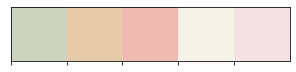

In [1]:
# CPU Libraries
import os
import random
import warnings
import pandas as pd
import numpy as np

import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

### Commenting out code from Kaggle book to replace try code above from fancyimpute import KNN, IterativeImputer

seed = 123
random.seed(seed)
np.random.seed(seed)

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

#so excited about this palette, though icecream may not be the best when doing predictions on diabetes...
icecream = ["#CCD4BF", "#E7CBA9", "#EEBAB2", "#F5F3E7", "#F5E2E4"]
sns.palplot(sns.color_palette(icecream))

## Import Data


In [2]:
train = pd.read_csv("TrainingWiDS2021.csv")
test = pd.read_csv("UnlabeledWiDS2021.csv")

In [3]:
train.shape

(130157, 181)

In [4]:
test.shape


(10234, 180)

In [5]:
encounter_id_test = test['encounter_id'].values

In [6]:
train.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,...,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,...,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


In [7]:
test.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,1,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,2,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,3,142038,10141,72,NaN,0,Caucasian,F,162.6,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,4,138628,10141,66,NaN,0,Caucasian,M,177.8,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,5,141682,10141,89,NaN,0,Caucasian,M,170.2,Direct Admit,...,NaN,NaN,NaN,0,0,0,0,0,0,0


## Remove day data

From the WiDS Datathon Webinar(https://www.youtube.com/watch?v=cZ-trv7-j7k) Dr. Celi noted that it would be more helpful if the h1 data were predictive of diabetes because then ICU staff could make a prediction faster than if they had to wait for a full day to be able to make a prediction.  I will run both h1 and d1 through the model that has provided me the best results thus far and then note the difference.  This model will be for the h1 data.  As such we will eliminate all d1 data. We will also remove Unnamed: 0.

In [8]:
train = train.drop(['Unnamed: 0',
'd1_albumin_max',
'd1_albumin_min',
'd1_arterial_pco2_max',
'd1_arterial_pco2_min',
'd1_arterial_ph_max',
'd1_arterial_ph_min',
'd1_arterial_po2_max',
'd1_arterial_po2_min',
'd1_bilirubin_max',
'd1_bilirubin_min',
'd1_bun_max',
'd1_bun_min',
'd1_calcium_max',
'd1_calcium_min',
'd1_creatinine_max',
'd1_creatinine_min',
'd1_diasbp_invasive_max',
'd1_diasbp_invasive_min',
'd1_diasbp_max',
'd1_diasbp_min',
'd1_diasbp_noninvasive_max',
'd1_diasbp_noninvasive_min',
'd1_glucose_max',
'd1_glucose_min',
'd1_hco3_max',
'd1_hco3_min',
'd1_heartrate_max',
'd1_heartrate_min',
'd1_hemaglobin_max',
'd1_hemaglobin_min',
'd1_hematocrit_max',
'd1_hematocrit_min',
'd1_inr_max',
'd1_inr_min',
'd1_lactate_max',
'd1_lactate_min',
'd1_mbp_invasive_max',
'd1_mbp_invasive_min',
'd1_mbp_max',
'd1_mbp_min',
'd1_mbp_noninvasive_max',
'd1_mbp_noninvasive_min',
'd1_pao2fio2ratio_max',
'd1_pao2fio2ratio_min',
'd1_platelets_max',
'd1_platelets_min',
'd1_potassium_max',
'd1_potassium_min',
'd1_resprate_max',
'd1_resprate_min',
'd1_sodium_max',
'd1_sodium_min',
'd1_spo2_max',
'd1_spo2_min',
'd1_sysbp_invasive_max',
'd1_sysbp_invasive_min',
'd1_sysbp_max',
'd1_sysbp_min',
'd1_sysbp_noninvasive_max',
'd1_sysbp_noninvasive_min',
'd1_temp_max',
'd1_temp_min',
'd1_wbc_max',
'd1_wbc_min'], axis=1)

In [9]:
train.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
2,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
3,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,...,337.0,337.0,0,0,0,0,0,0,0,0
4,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0


In [10]:
test = test.drop(['Unnamed: 0',
'd1_albumin_max',
'd1_albumin_min',
'd1_arterial_pco2_max',
'd1_arterial_pco2_min',
'd1_arterial_ph_max',
'd1_arterial_ph_min',
'd1_arterial_po2_max',
'd1_arterial_po2_min',
'd1_bilirubin_max',
'd1_bilirubin_min',
'd1_bun_max',
'd1_bun_min',
'd1_calcium_max',
'd1_calcium_min',
'd1_creatinine_max',
'd1_creatinine_min',
'd1_diasbp_invasive_max',
'd1_diasbp_invasive_min',
'd1_diasbp_max',
'd1_diasbp_min',
'd1_diasbp_noninvasive_max',
'd1_diasbp_noninvasive_min',
'd1_glucose_max',
'd1_glucose_min',
'd1_hco3_max',
'd1_hco3_min',
'd1_heartrate_max',
'd1_heartrate_min',
'd1_hemaglobin_max',
'd1_hemaglobin_min',
'd1_hematocrit_max',
'd1_hematocrit_min',
'd1_inr_max',
'd1_inr_min',
'd1_lactate_max',
'd1_lactate_min',
'd1_mbp_invasive_max',
'd1_mbp_invasive_min',
'd1_mbp_max',
'd1_mbp_min',
'd1_mbp_noninvasive_max',
'd1_mbp_noninvasive_min',
'd1_pao2fio2ratio_max',
'd1_pao2fio2ratio_min',
'd1_platelets_max',
'd1_platelets_min',
'd1_potassium_max',
'd1_potassium_min',
'd1_resprate_max',
'd1_resprate_min',
'd1_sodium_max',
'd1_sodium_min',
'd1_spo2_max',
'd1_spo2_min',
'd1_sysbp_invasive_max',
'd1_sysbp_invasive_min',
'd1_sysbp_max',
'd1_sysbp_min',
'd1_sysbp_noninvasive_max',
'd1_sysbp_noninvasive_min',
'd1_temp_max',
'd1_temp_min',
'd1_wbc_max',
'd1_wbc_min'], axis=1)

In [11]:
test.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,142038,10141,72,NaN,0,Caucasian,F,162.6,Floor,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,138628,10141,66,NaN,0,Caucasian,M,177.8,Floor,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,141682,10141,89,NaN,0,Caucasian,M,170.2,Direct Admit,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0


## Feature Engineering and Selection Using featurewiz library

There are now 116 columns in the dataset.  Featureviz can help us select the best features!

In [12]:
pip install featurewiz


Note: you may need to restart the kernel to use updated packages.


In [13]:
from featurewiz import featurewiz

Imported featurewiz: Auto_ViML's feature engg and selection library. Version=0.0.16
output = featurewiz(dataname, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')
Let featurewiz add features to your data! Set 'feature_engg' as: 'interactions' or 'groupby' or 'target'
                                


Skipping category encoding since no category encoders specified in input...
Shape of your Data Set loaded: (130157, 116)
    No GPU active on this device
    Running XGBoost using CPU parameters
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    115 Predictors classified...
        8 variable(s) removed since they were ID or low-information variables
#### Single_Label Binary_Classification Feature Selection Started ####
Starting feature engineering...this will take time...
Source X_train shape:  (130157, 107) | X_test shape:  (10234, 107)
##################################################
> Start preprocessing with 107 variables
> Generate Categorical Encoded features
> Generate Target Encoded categorical features
 + To know more, click: https://contrib.scikit-learn.org/category_encoders/targetencoder.html
 + added  6  additional Features using  TargetEncoder
> Cleaned NaNs in numeric features
#########################

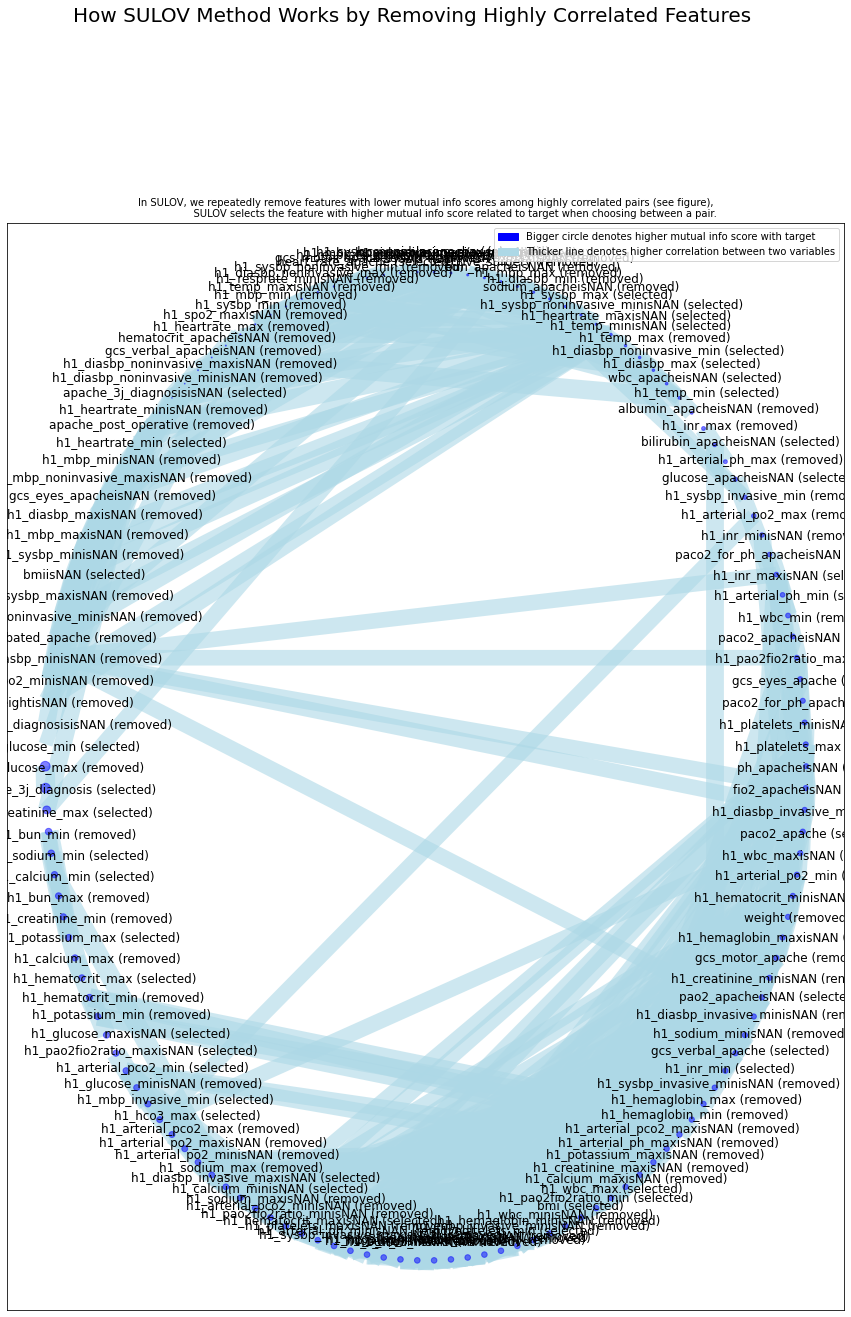

    Adding 6 categorical variables to reduced numeric variables  of 90
############## F E A T U R E   S E L E C T I O N  ####################
Current number of predictors = 96 
    Finding Important Features using Boosted Trees algorithm...
        using 96 variables...
        using 77 variables...
        using 58 variables...
        using 39 variables...
        using 20 variables...
        using 1 variables...
Selected 45 important features from your dataset
    Time taken (in seconds) = 232
Returning list of 45 important features and dataframe.
Returning 2 dataframes: train and test with 45 important features.


In [14]:
#define target
target = 'diabetes_mellitus'
output = featurewiz(dataname=train, target=target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data=test,
                    feature_engg=['target'], category_encoders='')


It returned 45 important features and took 232 second to run.


In [15]:
## there are two parts of the tuple output.
# One is the new train dataset and the other is new dataset
len(output)

2

## Using Auto_ViML
Now the we'll use autoviml on the new train and test sets that were created by featurewiz...
(autoviml is already installed)

In [16]:
from autoviml.Auto_ViML import Auto_ViML

Imported Auto_NLP version: 0.0.45.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)
Imported Auto_ViML version: 0.1.677. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            verbose=1)
            
The new Auto_ViML can solve multi-label, multi-output problems. Check if your version is >= 0.1.669
To get the latest version, perform "pip install autoviml --no-cache-dir --

In [17]:
idcol = "encounter_id"

In [18]:
encounter_id_test = test[idcol].values

In [19]:
traindf, testdf = output[0], output[1]
print(traindf.shape, testdf.shape)

(130157, 46) (10234, 45)


In [20]:
target

'diabetes_mellitus'

##############  D A T A   S E T  A N A L Y S I S  #######################
Training Set Shape = (130157, 46)
    Training Set Memory Usage = 30.16 MB
Test Set Shape = (10234, 45)
    Test Set Memory Usage = 2.28 MB
Single_Label Target: ['diabetes_mellitus']
Random shuffling the data set before training
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
       Class  -> Counts -> Percent
           0:  102006  ->   78.4%
           1:   28151  ->   21.6%
    Target diabetes_mellitus is already numeric. No transformation done.
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
Data Set Shape: 130157 rows, 45 cols
Too many columns to print
    Numeric Columns: ['glucose_apache', 'bmi', 'age', 'h1_glucose_min', 'bun_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'h1_hematocrit_max', 'h1_creatinine_max', 'h1_sysbp_max', 'h1_hco3_max', 'h1_diasbp_max', 'h1_diasbp_noninvasive_min

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.049567


0:	learn: 0.7893205	test: 0.7915258	best: 0.7915258 (0)	total: 218ms	remaining: 18m 11s
500:	learn: 0.8406050	test: 0.8325522	best: 0.8327443 (499)	total: 13.3s	remaining: 1m 59s
1000:	learn: 0.8520336	test: 0.8337815	best: 0.8342425 (940)	total: 27.1s	remaining: 1m 48s
1500:	learn: 0.8618007	test: 0.8349723	best: 0.8352412 (1430)	total: 40.3s	remaining: 1m 34s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.8352796558
bestIteration = 1505

Shrink model to first 1506 iterations.
    Actual training time (in seconds): 48
###########  Single_Label  M O D E L   R E S U L T S #################
5-fold Cross Validation logloss = 0.835279655808236
    CatBoost Best Parameters for Model: Iterations = 1505, learning_rate = 0.05
Finding Best Threshold for Highest F1 Score...


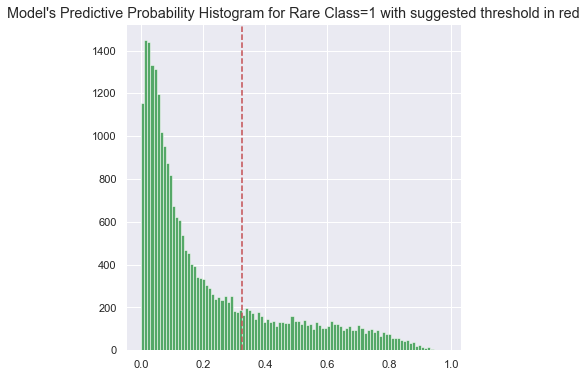

    Using threshold=0.5. However, 0.327 provides better F1=0.60 for rare class...
########################################################
CatBoost Model Prediction Results on Held Out CV Data Set:
    Regular Accuracy Score = 81.7%
Balanced Accuracy = 69.73% with Threshold = 0.50
Confusion Matrix:
[[19187  1215]
 [ 3073  2557]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     20402
           1       0.68      0.45      0.54      5630

    accuracy                           0.84     26032
   macro avg       0.77      0.70      0.72     26032
weighted avg       0.82      0.84      0.82     26032

Balanced Accuracy = 75.48% with Threshold = 0.33
Confusion Matrix:
[[17631  2771]
 [ 1996  3634]]
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     20402
           1       0.57      0.65      0.60      5630

    accuracy                           0.82     26032
   macro avg       0.73   

After multiple models, Ensemble Model Results:
Binary Class Model Metrics Report
#####################################################
    Accuracy          = 82.0%
    Balanced Accuracy = 71.5%
    Precision         = 59.4%
    Average Precision = 73.4%
    Recall            = 53.0%
    F1 Score          = 56.0%
#####################################################
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     20402
           1       0.59      0.53      0.56      5630

    accuracy                           0.82     26032
   macro avg       0.73      0.72      0.72     26032
weighted avg       0.81      0.82      0.82     26032

[[18366  2036]
 [ 2647  2983]]
#############################################################################
Single Model is better than Ensembling Models for this data set.


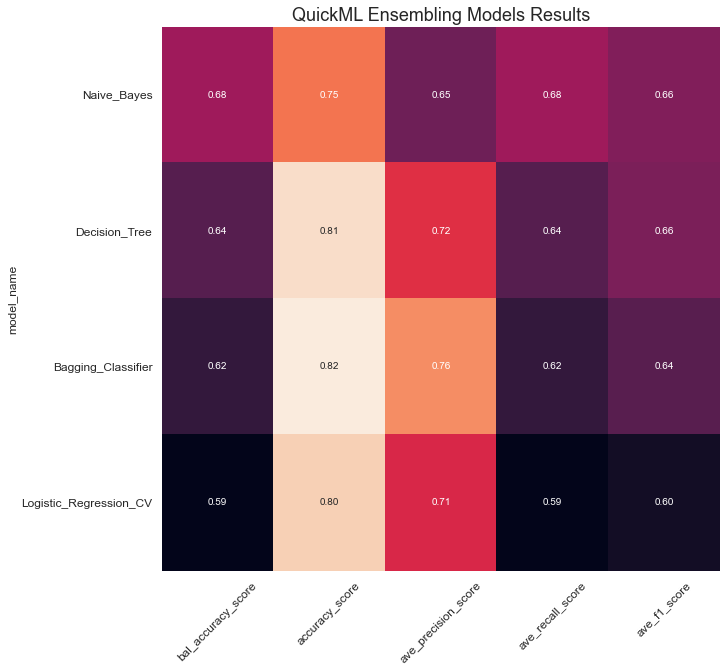

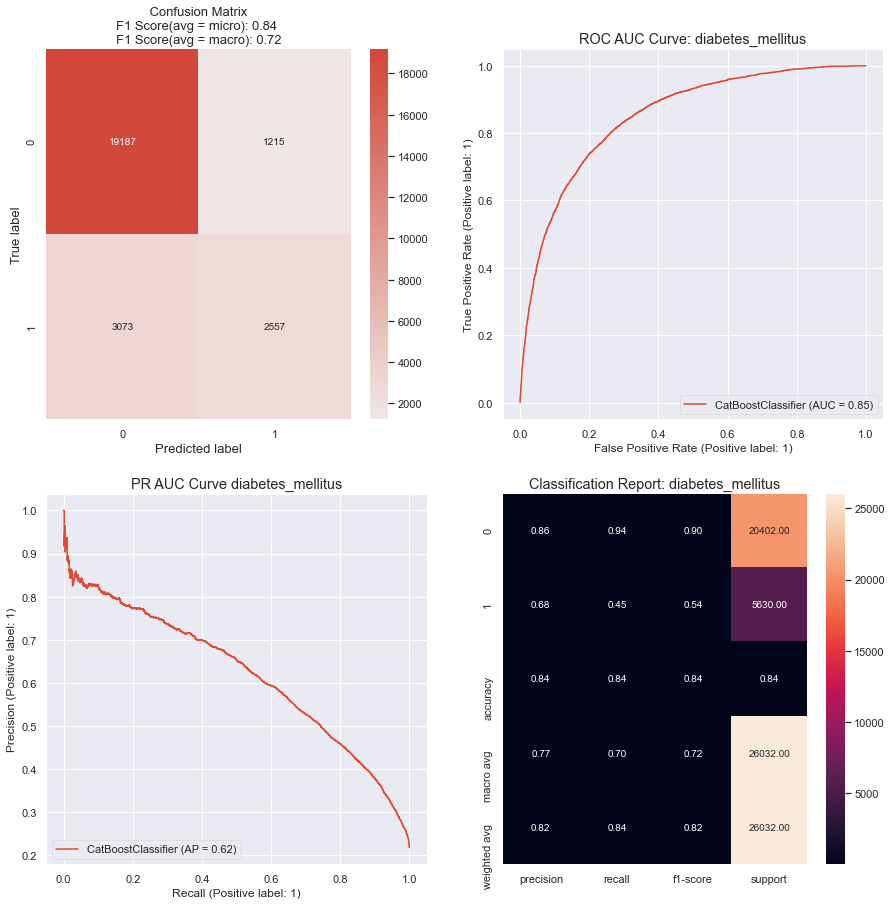

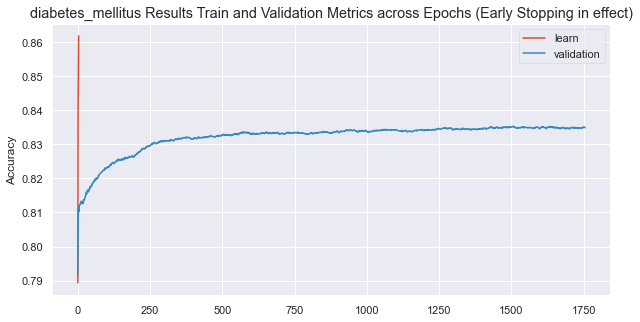

    Time taken for this Target (in seconds) = 81
    Binning_Flag set to False or there are no float vars in data set to be binned
    Setting best params for CatBoost model from Initial State since you cannot change params to a fitted Catboost model 
    Number of Categorical and Integer variables used in CatBoost training = 20
No MinMax scaling performed since scaling flag is set to false
#####   T R A I N I N G   M O D E L   O N    F U L L   T R A I N  D A T A  #############
0:	learn: 0.8034451	total: 33.8ms	remaining: 50.8s
500:	learn: 0.8387640	total: 15.4s	remaining: 30.8s
1000:	learn: 0.8486751	total: 30.7s	remaining: 15.5s
1500:	learn: 0.8569113	total: 47.3s	remaining: 126ms
1504:	learn: 0.8569958	total: 47.4s	remaining: 0us
     Actual Training time taken in seconds = 49
Training of models completed. Now starting predictions on test data...
    Making test Data predictions using modified Threshold = 0.327
    Calculating weighted average ensemble of 5 classifiers
    Plotting 

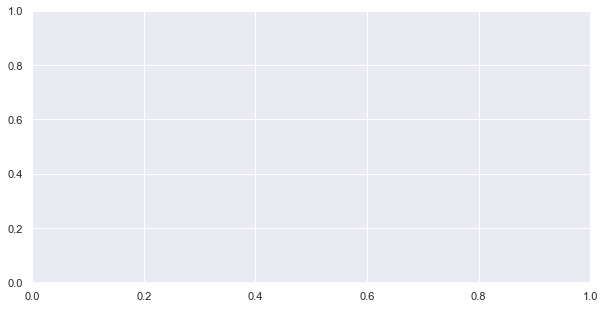

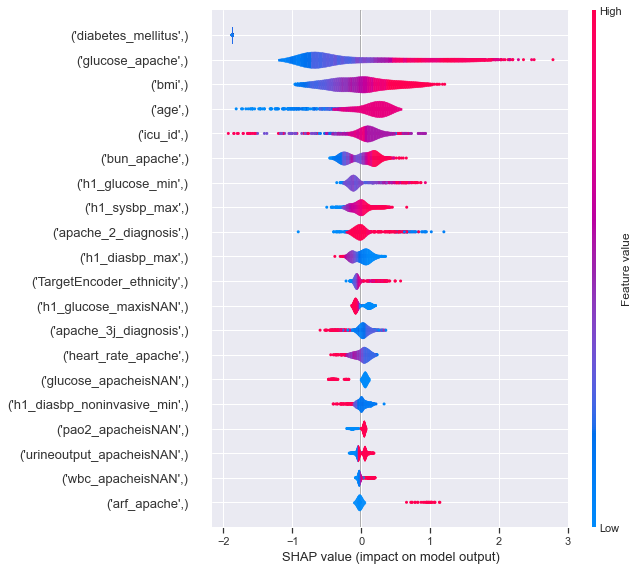

############### P R E D I C T I O N  O N  T E S T   C O M P L E T E D  #################
    Time taken thus far (in seconds) = 166
Writing Output files to disk...
    Saving predictions to .\diabetes_mellitus\diabetes_mellitus_Binary_Classification_test_modified.csv
    Saving predictions to .\diabetes_mellitus\diabetes_mellitus_Binary_Classification_submission.csv
    Saving predictions to .\diabetes_mellitus\diabetes_mellitus_Binary_Classification_train_modified.csv
###############  C O M P L E T E D  ################
Time Taken in mins = 2.8 for the Entire Process


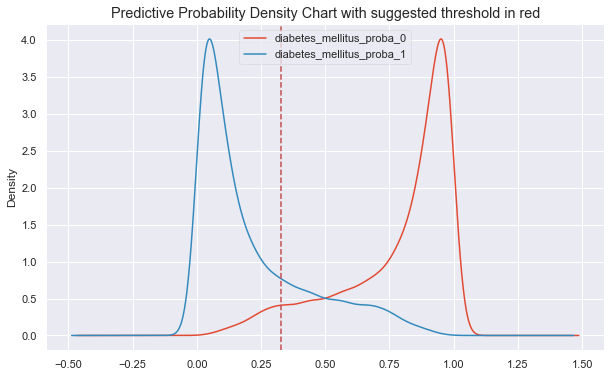

In [21]:
### we will turn off feature_reduction since we have already done that!
m, features, trainm, testm = Auto_ViML(traindf, target, testdf,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=False,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            verbose=2)

In [22]:
testm.head(1)

,glucose_apacheisNAN,arf_apache,ventilated_apache,h1_glucose_maxisNAN,ageisNAN,apache_3j_diagnosisisNAN,h1_hematocrit_maxisNAN,gcs_unable_apacheisNAN,h1_inr_maxisNAN,wbc_apacheisNAN,urineoutput_apacheisNAN,gcs_unable_apache,aids,pao2_apacheisNAN,temp_apacheisNAN,h1_calcium_minisNAN,bilirubin_apacheisNAN,h1_sysbp_noninvasive_minisNAN,bmiisNAN,h1_temp_minisNAN,glucose_apache,bmi,age,h1_glucose_min,bun_apache,apache_2_diagnosis,apache_3j_diagnosis,h1_hematocrit_max,h1_creatinine_max,h1_sysbp_max,h1_hco3_max,h1_diasbp_max,h1_diasbp_noninvasive_min,heart_rate_apache,h1_heartrate_min,h1_temp_min,gcs_verbal_apache,TargetEncoder_ethnicity,icu_id,icu_stay_type,ethnicity,icu_admit_source,icu_type,gender,hospital_admit_source,diabetes_mellitus_proba_0,diabetes_mellitus_proba_1,diabetes_mellitus_predictions,diabetes_mellitus_Logistic_Regression_CV_predictions,diabetes_mellitus_Decision_Tree_predictions,diabetes_mellitus_Naive_Bayes_predictions,diabetes_mellitus_Bagging_Classifier_predictions,diabetes_mellitus_CatBoost_predictions,diabetes_mellitus_Ensembled_predictions
0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,97.00,27.60,72,104.00,44.00,110.00,104.01,42.80,1.49,116.00,26.00,59.00,59.00,38.00,44.00,36.40,5.00,0.21,82,0,3,1,5,1,4,0.88,0.12,0.00,0,0,0,0,0.00,0


In [23]:
# Add encounter_id and diabetes_mellitus back to the dataframes
subm = pd.DataFrame([], columns = [idcol,target])
subm[target] = testm[target+'_proba_1'].values
subm[idcol] = encounter_id_test
subm.head()

,encounter_id,diabetes_mellitus
0,144740,0.12
1,141990,0.35
2,142038,0.08
3,138628,0.12
4,141682,0.21


In [24]:
subm.to_csv("JDsub7.csv", index=False)